In [1]:
'''
'''
import warnings

# Seed
seed = 0
# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read and standarize the dataset
df = pd.read_csv('data/selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
df = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns.values)
df['target'] = y

# Divide dataframe depending on target
df_correct = df.loc[df['target'] == 1]
X_correct = df_correct.iloc[:,:-1]
y_correct = df_correct.iloc[:,-1].reset_index(drop=True)

df_incorrect = df.loc[df['target'] == 0]
X_incorrect = df_incorrect.iloc[:,:-1]
y_incorrect = df_incorrect.iloc[:,-1].reset_index(drop=True)

# Print each target shape
print('Target 1 shape: ' + str(df_correct.shape))
print('Target 0 shape: ' + str(df_incorrect.shape))

Target 1 shape: (5055, 39)
Target 0 shape: (4959, 39)


# Normality test

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

#### Visual normality test

Methods for plotting the data and qualitatively evaluating whether the data looks Gaussian.

In [3]:
'''
Histogram Plot

In the histogram, the data is divided into a pre-specified number of groups 
called bins. The data is then sorted into each bin and the count of the
number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship,
and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the
familiar bell shape.
'''
from matplotlib import pyplot

def normality_test_histogram(data): 
    # histogram plot
    pyplot.hist(data)
    pyplot.show()

In [4]:
'''
Quantile-Quantile Plot

This plot generates its own sample of the idealized distribution that we are 
comparing with, in this case the Gaussian distribution. The idealized samples 
are divided into groups (e.g. 5), called quantiles. Each data point in the
sample is paired with a similar member from the idealized distribution at the
same cumulative distribution.
'''
from statsmodels.graphics.gofplots import qqplot

def normality_test_qqplot(data): 
    qqplot(data, line='s')
    pyplot.show()

#### Statistical Tests

Methods that calculate statistics on the data and quantify how likely it is that the data was drawn from a Gaussian distribution.

In [5]:
from scipy.stats import shapiro

def normality_test_shapiro(data): 
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [6]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest

def normality_test_k2(data): 
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

# PCA

In [7]:
'''
'''
from sklearn.decomposition import PCA
from models.model import ReconstructionErrorModel

# Fit reconstruction error model with correct data
model = ReconstructionErrorModel(X_correct, model=PCA(n_components=0.9))

# Calculate anomaly threshold with correct data
threshold = np.std(model.predict(X_correct)) * 3

# Print principal components
print('%i Principal Components' % len(model.get_model().explained_variance_))

12 Principal Components


Statistics=0.994, p=0.055
Sample looks Gaussian (fail to reject H0)
Statistics=0.994, p=0.055
Sample looks Gaussian (fail to reject H0)


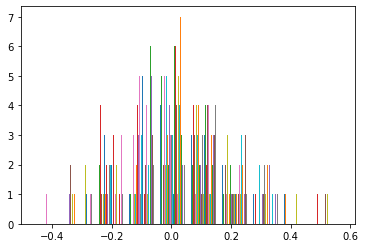

In [8]:
normality_test_shapiro(model.get_model().components_)
normality_test_k2(model.get_model().components_)
normality_test_histogram(model.get_model().components_)

In [9]:
'''
landa = 1 / np.mean(model.predict(X_correct))
threshold = 5.9 / landa
threshold
'''

'\nlanda = 1 / np.mean(model.predict(X_correct))\nthreshold = 5.9 / landa\nthreshold\n'

In [10]:
'''
'''
# Calculate how many correct instances are detected as anomalies
errors = model.predict(X_correct)
anomalies = np.where(errors > threshold)[0]
print('Anomalies with correct data %s' % str(len(anomalies)))

# Calculate how many correct instances are detected as anomalies
errors = model.predict(X_incorrect)
anomalies = np.where(errors > threshold)[0]
print('Anomalies with incorrect data %s' % str(len(anomalies)))

Anomalies with correct data 84
Anomalies with incorrect data 1117


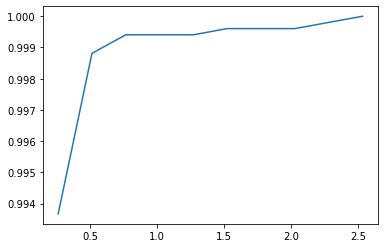

In [11]:
import matplotlib.pyplot as plt

Z = model.predict(X_correct)
N = Z.size

# cummulative distribution function
H,X1 = np.histogram( Z, bins = 10, normed = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx

plt.plot(X1[1:], F1)
plt.show()

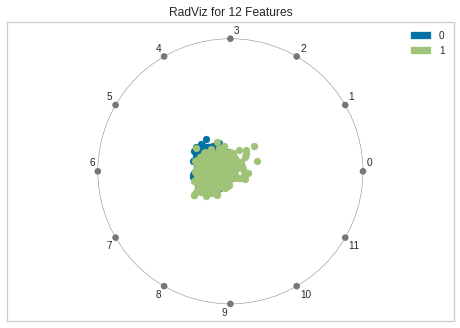

In [12]:
'''
'''         
from yellowbrick.features import RadViz

# Instantiate the visualizer
visualizer = RadViz()

# Fit the data to the visualizer
data = pd.DataFrame(model.get_model().transform(X_incorrect))
data['target'] = 0

for index in anomalies:
    data.loc[index, 'target'] = 1

X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

visualizer.fit(X_data, y_data)           

# Transform the data
visualizer.transform(X_data)     

# Finalize and render the figure
visualizer.show()   

# Hotelling T2

Hotelling's T2 (T-Squared), Q residuals, and their corresponding contributions, are summary statistics which help explain how well a model is describing a given sample, and why that sample has its observed scores in a given model. 

The null hypothesis is that there is no difference between our (multivariate) sample mean and the expected mean. 

The alternative hypothesis is that there is a difference.

In [13]:
# implement

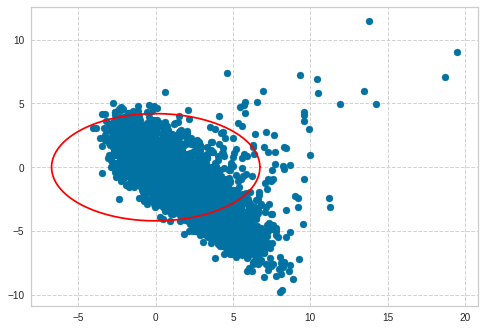

In [14]:
'''
'''
import matplotlib.pyplot as plt
import scipy, random

dataProject = model.get_model().transform(X_incorrect)

#Calculate ellipse bounds and plot with scores
theta = np.concatenate((np.linspace(-np.pi, np.pi, 50), np.linspace(np.pi, -np.pi, 50)))
circle = np.array((np.cos(theta), np.sin(theta)))
sigma = np.cov(np.array((dataProject[:, 0], dataProject[:, 1])))
ed = np.sqrt(scipy.stats.chi2.ppf(0.95, 2))
ell = np.transpose(circle).dot(np.linalg.cholesky(sigma) * ed)
a, b = np.max(ell[: ,0]), np.max(ell[: ,1]) #95% ellipse bounds
t = np.linspace(0, 2 * np.pi, 100)

plt.scatter(dataProject[:, 0], dataProject[:, 1])
plt.plot(a * np.cos(t), b * np.sin(t), color = 'red')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# SHAP

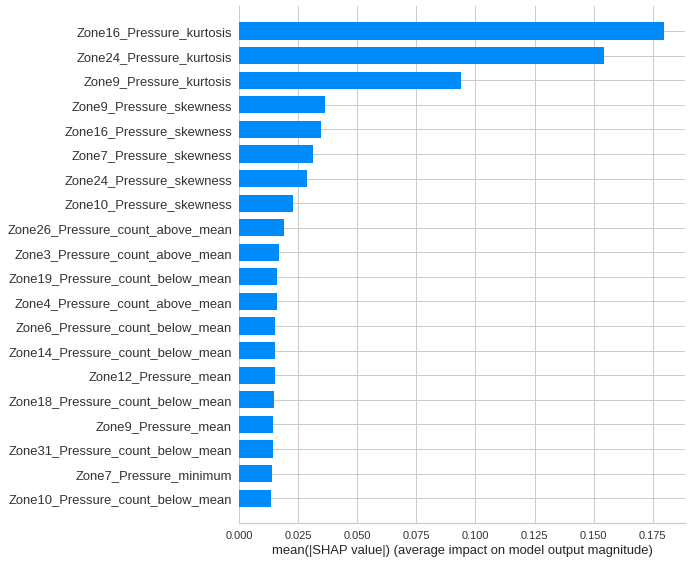

In [15]:
'''
'''
import shap

# Summarize training dataset (only instances detected as anomaly)
anomaly_instances = X_incorrect.iloc[anomalies,:].reset_index(drop=True)
train_summary = shap.kmeans(anomaly_instances, 10)

# Calculate anomalies shap values
explainer = shap.KernelExplainer(model.predict, train_summary)
shap_values = explainer.shap_values(anomaly_instances)
df_shap = pd.DataFrame(shap_values, columns=anomaly_instances.columns.values)

# Print global explanation with shap values
shap.summary_plot(df_shap, anomaly_instances, plot_type="bar")

# Clustering

In [16]:
'''
'''
from sklearn.cluster import DBSCAN

# Fit DBSCAN clustering algorithm
db_model = DBSCAN(eps=0.5, min_samples=5).fit(df_shap)
labels = db_model.labels_

# Calculate number of clusters and noise points
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print number of clusters and noise points
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 31


# Clusters explainability

CLUSTER 0 
INSTANCES 1081


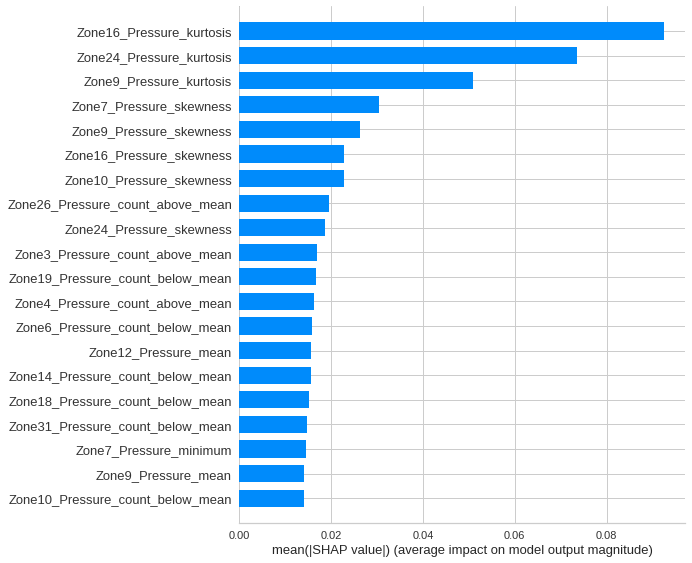

CLUSTER 1 
INSTANCES 5


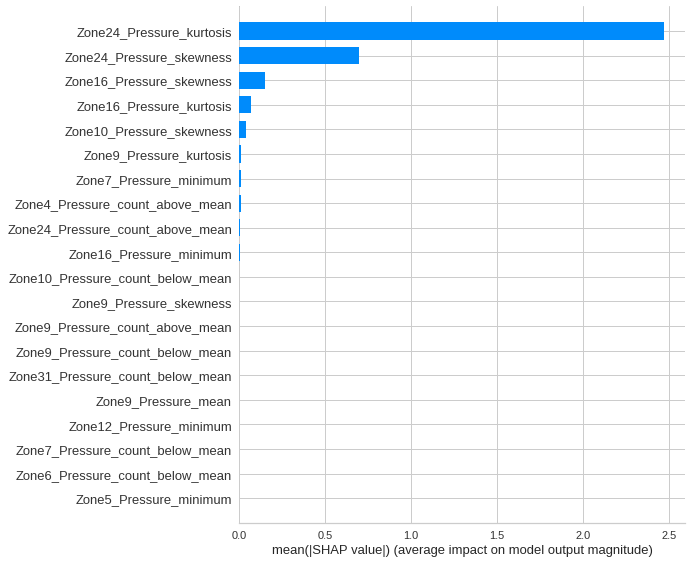

In [17]:
'''
'''
# Make a copy of instances and shap values dataframes
instances = anomaly_instances.copy()
shap_values = df_shap.copy()

# Classify instances and their shap values indicating the cluster number
instances['cluster'] = labels
shap_values['cluster'] = labels

# Generate each clusters explanation
for cluster in np.unique(labels):
    if cluster != -1:
        cluster_instances = instances.loc[instances['cluster'] == cluster].iloc[:,:-1]        
        cluster_shaps = shap_values.loc[shap_values['cluster'] == cluster].iloc[:,:-1]   
        print("CLUSTER {} \nINSTANCES {}".format(cluster, len(cluster_instances)))      
        shap.summary_plot(cluster_shaps, cluster_instances, plot_type="bar")           